In [1]:
import fitsio as fio
import numpy as np
import os, sys
import glob
from matplotlib import pyplot as plt
import matplotlib
import proplot as pplt
from tqdm import tqdm
import h5py as h5
%matplotlib inline

def flux2mag(flux, zero_pt=30):
    return zero_pt - 2.5 * np.log10(flux)

# Get Y3 catalog 

In [2]:
f = h5.File('/global/cfs/cdirs/des/www/y3_cats/Y3_mastercat___UNBLIND___final_v1.1_12_22_20.h5', 'r')

In [4]:
pz_data = np.array(f.get('/catalog/sompz/unsheared/bhat'))[m]

In [5]:
msk = (pz_data == 1)

In [14]:
np.array(f.get('/catalog/metacal/unsheared/'))['e_1']

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [20]:
f.get('/index/').keys()

<KeysViewHDF5 ['coadd_object_id', 'gold', 'maglim', 'mask', 'metacal', 'redmagic', 'select', 'select_1m', 'select_1m_bin1', 'select_1m_bin2', 'select_1m_bin3', 'select_1m_bin4', 'select_1p', 'select_1p_bin1', 'select_1p_bin2', 'select_1p_bin3', 'select_1p_bin4', 'select_2m', 'select_2m_bin1', 'select_2m_bin2', 'select_2m_bin3', 'select_2m_bin4', 'select_2p', 'select_2p_bin1', 'select_2p_bin2', 'select_2p_bin3', 'select_2p_bin4', 'select_bin1', 'select_bin2', 'select_bin3', 'select_bin4']>

In [5]:
m = np.array(f.get('/index/select'))
m_1p = np.array(f.get('/index/select_1p'))

In [ ]:
m = f['/index/select'][:]

ERROR! Session/line number was not unique in database. History logging moved to new session 502


In [6]:
d_1p = f.get('/catalog/metacal/sheared_1p')
d_1m = f.get('/catalog/metacal/sheared_1m')
d_2p = f.get('/catalog/metacal/sheared_2p')
d_2m = f.get('/catalog/metacal/sheared_2m')
d_noshear = f.get('/catalog/metacal/unsheared')
# d_gold = f.get('/catalog/gold')

In [11]:
w = np.array(d_noshear['weight'])[m]
w_1p = np.array(d_1p['weight'])[m_1p]
print(w, w_1p)

[32.7504844  41.16026567 44.41307    ... 40.2746443  45.48614938
 11.63795655] [32.7504844  41.16026567 42.09043925 ... 40.2746443  45.48614938
 11.01259931]


In [ ]:
d_ = d_noshear['ra'][m]

In [ ]:
d_noshear.keys()

In [ ]:
gold_flags_fore = np.array(d_gold.get('flags_foreground'))
gold_flags_badregion = np.array(d_gold.get('flags_badregions'))
gold_flags_gold = np.array(d_gold.get('flags_gold'))
gold_flags_footprint = np.array(d_gold.get('flags_footprint'))


msk = ((gold_flags_fore == 0) & 
       (gold_flags_badregion < 2) & 
       (gold_flags_gold < 8) & 
       (gold_flags_footprint == 1))
del gold_flags_fore
del gold_flags_badregion
del gold_flags_gold
del gold_flags_footprint

In [ ]:
flags = np.array(d_noshear.get('flags'))[msk]
snr = np.array(d_noshear.get('snr'))[msk]
size_ratio = np.array(d_noshear.get('size_ratio'))[msk]
T = np.array(d_noshear.get('T'))[msk]
mag_r = flux2mag(np.array(d_noshear.get('flux_r')))[msk]
mag_i = flux2mag(np.array(d_noshear.get('flux_i')))[msk]
mag_z = flux2mag(np.array(d_noshear.get('flux_z')))[msk]
e1 = np.array(d_noshear.get('e_1'))[msk]
e2 = np.array(d_noshear.get('e_2'))[msk]

In [ ]:
print(len(e1))

In [ ]:
# Cuts based on https://cdcvs.fnal.gov/redmine/projects/des-sc/wiki/Y3kp_catalogs
rmi = mag_r - mag_i
zmi = mag_z - mag_i
msk_mcal = ((flags == 0) & 
       (snr > 10) & 
       (snr < 1000) &
       (size_ratio > 0.5) &
       (T < 10) &
       ~((T > 2) & (snr < 30)) &
       ((mag_i > 18) & (mag_i < 23.5)) & 
       ((mag_r > 15) & (mag_r < 26)) &
       ((mag_z > 15) & (mag_z < 26)) &
       ((rmi > -1.5) & (rmi < 4)) &
       ((zmi > -1.5) & (zmi < 4)) &
       ~((np.log10(T) < (22.5 - mag_r)/2.5) & (np.sqrt(e1**2 + e2**2) > 0.8)))

del flags
del snr
del size_ratio
del T
del mag_r
del mag_i
del mag_z

In [ ]:
len(e1[msk_mcal])

In [ ]:
R11 = np.array(d_noshear.get('R11'))[msk][msk_mcal]
R22 = np.array(d_noshear.get('R22'))[msk][msk_mcal]
w = np.array(d_noshear.get('weight'))[msk][msk_mcal]
g1_cov = np.array(d_noshear.get('covmat_1_1'))[msk][msk_mcal]
g2_cov = np.array(d_noshear.get('covmat_2_2'))[msk][msk_mcal]
ra = np.array(d_noshear.get('ra'))[msk][msk_mcal]
dec = np.array(d_noshear.get('dec'))[msk][msk_mcal]

In [8]:
e1 = np.array(d_noshear.get('e_1'))[m]
e2 = np.array(d_noshear.get('e_2'))[m]
T = np.array(d_noshear.get('T'))[m]
size_ratio = np.array(d_noshear.get('size_ratio'))[m]
s2n = np.array(d_noshear.get('snr'))[m]
R11 = np.array(d_noshear.get('R11'))[m]
R22 = np.array(d_noshear.get('R22'))[m]
w = np.array(d_noshear.get('weight'))[m]
g1_cov = np.array(d_noshear.get('covmat_1_1'))[m]
g2_cov = np.array(d_noshear.get('covmat_2_2'))[m]
ra = np.array(d_noshear.get('ra'))[m]
dec = np.array(d_noshear.get('dec'))[m]

In [ ]:
mag_g = flux2mag(np.array(d_gold.get('SOF_CM_MAG_CORRECTED_G')))[m]
mag_i = flux2mag(np.array(d_gold.get('SOF_CM_MAG_CORRECTED_I')))[m]

In [ ]:
len(e1)

In [9]:
res = np.zeros(len(e1), dtype=[('ra','f8'), ('dec','f8'), ('g1','f8'), ('g2','f8'), ('T','f8'), ('size_ratio','f8'), ('s2n','f8'), ('R11','f8'), ('R22','f8'), ('w','f8'), ('g1_cov','f8'), ('g2_cov','f8'), ('mag_g', 'f8'), ('mag_i', 'f8')])
res['g1'] = e1
res['g2'] = e2
res['T'] = T
res['size_ratio'] = size_ratio
res['s2n'] = s2n
res['R11'] = R11
res['R22'] = R22
res['w'] = w
res['g1_cov'] = g1_cov
res['g2_cov'] = g2_cov
res['ra'] = ra
res['dec'] = dec
res['mag_g'] = mag_g
res['mag_i'] = mag_i

ERROR! Session/line number was not unique in database. History logging moved to new session 503


NameError: name 'mag_g' is not defined

In [ ]:
fio.write('/global/cscratch1/sd/myamamot/des-y6-analysis/y6_measurement/y3_mcal_catalog_matched.fits', res)

# Compare Y3 and Y6 data

In [2]:
d_y6 = fio.read('/global/cscratch1/sd/myamamot/des-y6-analysis/y6_measurement/y6_catalog4matching.fits')
# d_y3 = fio.read('/global/cscratch1/sd/myamamot/des-y6-analysis/y6_measurement/y3_mcal_catalog_matched.fits')

In [3]:
y6_ind = np.load('/global/cscratch1/sd/myamamot/des-y6-analysis/y6_measurement/knn_all_matched_index.npy')
y6_ind_unique, unique_ind = np.unique(y6_ind, return_index=True)
matched_dist = np.load('/global/cscratch1/sd/myamamot/des-y6-analysis/y6_measurement/knn_all_matched_dist.npy')
matched_dist_unique = matched_dist[unique_ind]
print(len(y6_ind), len(matched_dist))

100204026 100204026


In [5]:
print(len(d_y6), len(matched_dist))

95750856 100204026


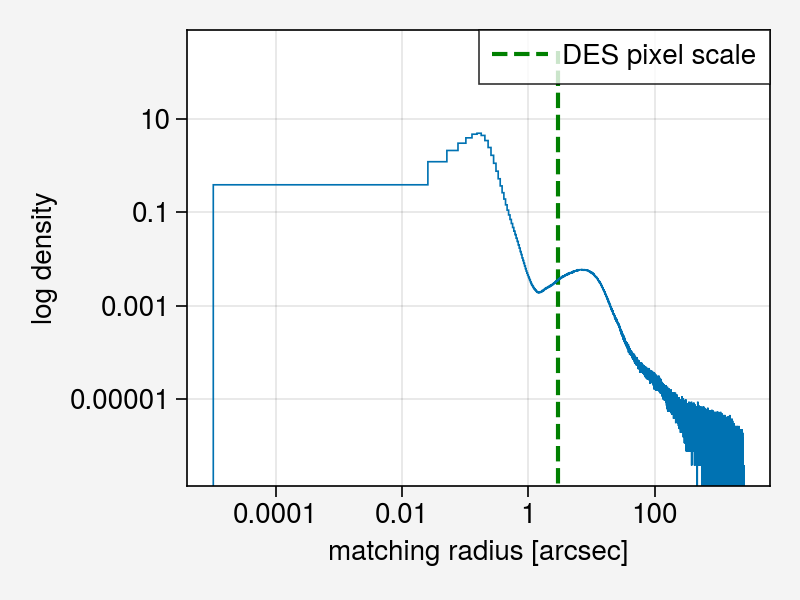

In [7]:

matplotlib.rcParams.update({'font.size': 10})
fig,ax = plt.subplots(figsize=(4,3))
values, bins, _ = ax.hist(matched_dist*3600, bins=100000, histtype='step', log=True, density=True)
ax.vlines(3, 0, 2.8e2, ls='--', color='g', label='DES pixel scale')
# ax.set_xlim(-0.1, 60)
ax.set_xscale('log')
# ax.set_yscale('log')
ax.set_xlabel('matching radius [arcsec]')
ax.set_ylabel('log density')
ax.legend()

plt.tight_layout()

In [8]:
diff = np.absolute(bins-3)
ind = np.argmin(diff)

area = sum(np.diff(bins[:ind])*values[:ind-1])
print(area*100)

92.04350332191243


## From slice info, visualize the objects

In [7]:
# any object whose matching distance is large.
msk_dist = matched_dist_unique*3600 > 1
msk_ind = y6_ind_unique[msk_dist]
d_objs = d_y6[msk_ind]

In [8]:
np.random.seed(314)
d_random = np.random.choice(d_objs, size=20)

Connecting to DB ** desoper ** ...
Error when trying to connect to database: DPI-1047: Cannot locate a 64-bit Oracle Client library: "libclntsh.so: cannot open shared object file: No such file or directory". See https://cx-oracle.readthedocs.io/en/latest/user_guide/installation.html for help

   Retrying...


 ** Could not successfully connect to DB. Try again later. Aborting. ** 



UnboundLocalError: local variable 'mlist' referenced before assignment

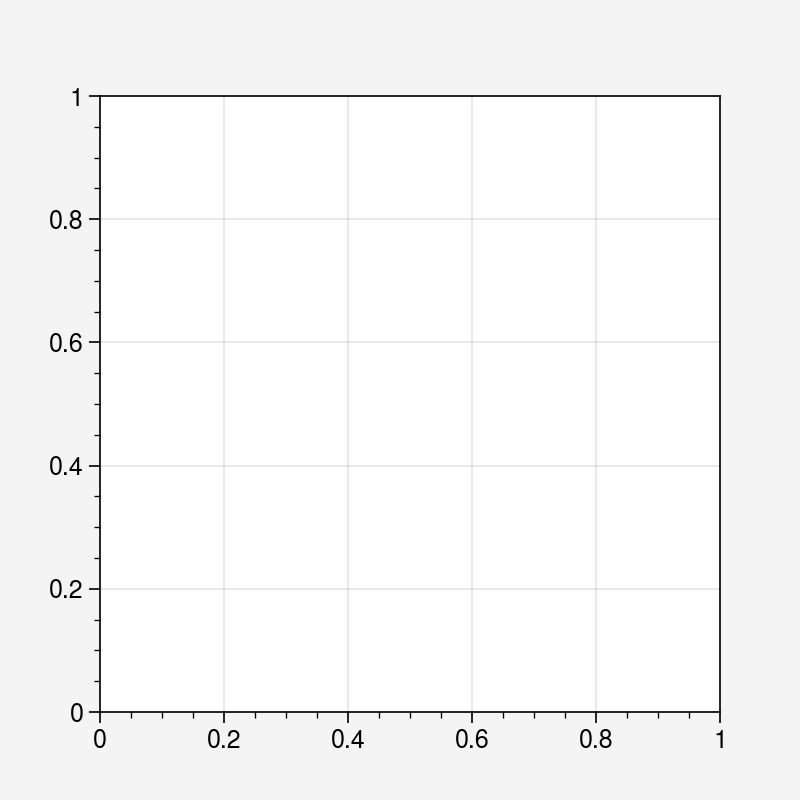

In [29]:
from des_y6utils import viz, mdet
import meds
import ngmix
from pizza_cutter.slice_utils.locate import build_slice_locations
fig,ax = plt.subplots()

# meds_files = np.array(glob.glob("/global/cfs/cdirs/des/myamamot/pizza-slice/data/*_r_pizza-cutter-slices.fits.fz"))
tnames = np.array([f.split('/')[-1].split('_')[0] for f in meds_files])
rows, cols, srows, scols = build_slice_locations(central_size=100, buffer_size=50, image_width=10000)
for obj,tilename in enumerate(d_random['tilename']):

    # meds_file = meds_files[tnames == tilename][0]
    d_ = d_random[obj]
    slice_id = int(d_['slice_id'])
    scol = scols[slice_id]
    srow = srows[slice_id]
    
    sx = d_['x'] - scol
    sy = d_['y'] - srow
    
    with viz.get_ngmix_meds_reader(tilename) as mbmeds:
        mbobs = mbmeds.get_mbobs(slice_id)
        for ii in range(1,2): # g: 0, r: 1, i: 2, z: 3
            im = mbobs[ii][0].image
            im_cutout = im[sy-32:sy+32, sx-32:sx+32]
            # fio.write('./data/pg_cuts/'+tilename+'_'+bands[ii]+str(obj)+'.fits', im_cutout) 
            ax.imshow(im_cutout)
    break